In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from networkx.algorithms.tree.branchings import Edmonds
from collections import defaultdict
% matplotlib inline

In [2]:
labels = ["nsubj", "dobj", "iobj", "det", "nmod", "amod", "cc", "conj"]
sent = "This is a test sentence".split()
def matrix_to_graph(A, sent, labels, digraph=False):
    """
    Turns a numpy matrix to a networkx graph
    """
    k = A.shape[0]
    nodes = range(k)
    if digraph:
        # This function turns a np matrix into a directed graph
        G = nx.from_numpy_matrix(A, create_using=nx.DiGraph())
        # Trying to get labels on the arcs... No succes yet
        labels = {(i, j, A[i,j]): np.random.choice(labels) for i,j in itertools.product(nodes, nodes)}
    else:
        G = nx.from_numpy_matrix(A)
        
    for k, w in enumerate(sent):
        G.node[k]['word'] = w
        
    weighted_edges = {(i, j): A[i,j] for i,j in itertools.product(nodes, nodes)}
    return G, weighted_edges

def minimum_tree(G):
    edmonds = Edmonds(G)
    tree = edmonds.find_optimum()
    return tree

In [3]:
def draw_nice(G, custom_labels = False):
    colors = [G[i][j]['weight'] for (i,j) in G.edges()]

    node_labels = {}
    if custom_labels:
        for index in G.nodes:
            node_labels[index] = G.nodes[index]['word'];
    positions = nx.spring_layout( G )
    nx.draw(G, node_color='#A0CBE2', pos=positions, edge_color = colors,
            width=2, edge_cmap=plt.cm.Blues,with_labels=not custom_labels)
    if node_labels:
        nx.draw_networkx_labels(G,positions, node_labels)
        
    labels = nx.get_edge_attributes(G,'weight')
    for key in labels:
        labels[key] = "{0:.2f}".format(labels[key])
    nx.draw_networkx_edge_labels(G,pos=positions,edge_labels=labels)
    plt.show()

In [4]:
def get_score(T):
    """
    For a graph/tree "T", returns the sum of all
    edges' weight
    """
    score = 0
    for i, j in T.edges:
        score += T.get_edge_data(i,j)['weight']
    return score
    
def argmax(G,v):
    """
    Given the graph "G" and a node "v", this function 
    returns, for node "v", the incoming edge of maximum weight 
    """
    maxim = -np.inf
    max_edge = ()
    for i,j in G.edges():
        if j == v and G.get_edge_data(i,j)['weight'] > maxim:
            maxim = G.get_edge_data(i,j)['weight']
            max_edge = (i,j)
    return max_edge

def get_nodes(C):
    """
    This function returns all the nodes from 
    cycle "C"
    """
    lista = []
    for i,j,_ in C:
        lista.append(i)
        lista.append(j)
    return list(set(lista))

def get_incoming_edge(n, C):
    """
    Given the cycle "C" and the node "n", this function returns
    the edge from the cycle "C" goes from one node to node "n".
    """
    for i,j,_ in C:
        if j == n:
            return (i,j)
    assert False
    

def prepare(G, root=0):
    """
    We first remove any edge from G.edges whose destination is r.
    We may also replace any set of parallel edges with a single edge 
    with weight equal to the maximum of the weights of these parallel edges.
    """
    G_new = nx.DiGraph()
    dictionary = defaultdict(lambda: -np.inf)
    for edge in G.edges:
        if edge[1] != root and edge[0] != edge[1]:
            if dictionary[edge] < G.get_edge_data(edge[0], edge[1])['weight']:
                dictionary[edge] = G.get_edge_data(edge[0], edge[1])['weight']
    for key in dictionary.keys():
        G_new.add_edge(key[0], key[1], weight=dictionary[key])
    
    return G_new

def greedy(G, root=0):
    """
    Now, for each node v other than the root, find the edge incoming to v of highest 
    weight (with ties broken arbitrarily).
    """
    P = nx.DiGraph()
    for node in G.nodes():
        if node != root:
            max_edge = argmax(G, node)
            P.add_edge(max_edge[0], max_edge[1], weight = G.get_edge_data(max_edge[0], max_edge[1])['weight'])
    P.add_nodes_from(G.nodes)
    return P

def cleanup(G,root=0):
    """
    Given a graph "G", this function returns a graph "G'" that has the same nodes and edges as graph
    "G", but for each edge "E", the weight is obtained by substractig from the initial weight, the maximum weight
    of all the edges going to that ege "E"'s destination node.
    This function also returns a ductionary that is used to reconstrcut the initial weights.
    """
    G_cleaned = nx.DiGraph()
    dictionary = {}
    for node in G.nodes:
        if node != root:
            max_edge = argmax(G, node)
            max_score =  G.get_edge_data(max_edge[0], max_edge[1])['weight']
            dictionary[node] = max_score
    
    for edge in G.edges:
        if edge[1] != root:
            G_cleaned.add_edge(edge[0], edge[1], weight=G.get_edge_data(edge[0], edge[1])['weight'] - dictionary[edge[1]])
    
    return G_cleaned, dictionary

def uncleanup(G,dictionary_cleanup,root=0):
    """
    The opposite of "cleanup(G,root=0)" function. 
    See: cleanup(G,root=0)
    """
    G_uncleaned = nx.DiGraph()
    for i,j in G.edges:
        if j != root:
            G_uncleaned.add_edge(i,j, weight=G.get_edge_data(i, j)['weight'] + dictionary_cleanup[j] )
    return G_uncleaned

def contract(G, C, root=0, step=0):
    new_node = "new_" + str(step)
    nodes = get_nodes(C)
    G_contracted = nx.DiGraph()
    
    restore_dictionary = {}
    add_dictionary = defaultdict(lambda: -np.inf)
    
    for i,j in G.edges():
        if i not in nodes and j in nodes:
            if add_dictionary[(i,new_node)] < G.get_edge_data(i, j)['weight']:
                add_dictionary[(i,new_node)] = G.get_edge_data(i, j)['weight']
                restore_dictionary[(i,new_node)] = (i, j, G.get_edge_data(i, j)['weight'])
            continue
                
        if i in nodes and j not in nodes:
            if add_dictionary[(new_node,j)] < G.get_edge_data(i, j)['weight']:
                add_dictionary[(new_node,j)] = G.get_edge_data(i, j)['weight']
                restore_dictionary[(new_node,j)] = (i, j, G.get_edge_data(i, j)['weight'])
            continue
        
        if i not in nodes and j not in nodes:
            add_dictionary[(i,j)] =  G.get_edge_data(i, j)['weight']
            continue
        
        if i in nodes and j in nodes:
            restore_dictionary[(i,j)] = (i, j, G.get_edge_data(i, j)['weight'])
            continue
        
    for key in add_dictionary.keys():
        G_contracted.add_edge(key[0], key[1], weight=add_dictionary[key])
    
    
    return G_contracted, restore_dictionary

def expand(T_contracted, C, restore_dictionary, root=0, step=0):
    new_node = "new_" + str(step)
    nodes = get_nodes(C)
    G_expanded = nx.DiGraph()
    
    for i,j in T_contracted.edges:
        if i not in nodes and j not in nodes and i != new_node and j != new_node:
            G_expanded.add_edge(i,j, weight=T_contracted.get_edge_data(i,j)['weight'])
            continue
        
        if i == new_node:
            G_expanded.add_edge(restore_dictionary[(i,j)][0],j, weight=restore_dictionary[(i,j)][2])
            continue
        
        if j == new_node:
            G_expanded.add_edge(i,restore_dictionary[(i,j)][1], weight=restore_dictionary[(i,j)][2])
            
            # but also search which edge to delete from C
            edge_to_remove = get_incoming_edge(restore_dictionary[(i,j)][1], C)
            continue
            
    # add all edges form C, except the one we just 'deleted'
    for i,j,_ in C:
        if (i,j) != edge_to_remove:
            G_expanded.add_edge(i,j, weight=restore_dictionary[(i,j)][2] )
    
    return G_expanded

def max_tree(G, root=0, step=0): 
    G=prepare(G,root) 
    P=greedy(G,root)
    if nx.is_arborescence(P):
        return P
    else: # there is a cycle
        C  = nx.find_cycle(P, orientation='ignore')
        G, dictionary_cleanup = cleanup(G,root)
        G_contracted, dictionary = contract(G, C, root=root, step=step)
        T_contracted = max_tree(G_contracted, root=root, step=step+1)
        T_expanded = expand(T_contracted, C, dictionary, root=root, step=step)
        T_expanded = uncleanup(T_expanded,dictionary_cleanup,root=root)
        return T_expanded

In [5]:
def is_same_tree(tree1, tree2):
    dif1 = nx.difference(tree1,tree2)
    dif2 = nx.difference(tree2,tree1)
    same_graph = len(dif1.edges) == 0 and len(dif2.edges) == 0
    return same_graph

def test():
    labels = ["nsubj", "dobj", "iobj", "det", "nmod", "amod", "cc", "conj"]
    sentence = "Eins Zwei Drei Vier Funf Sechs Sieben Acht Neun".split()
    
    wrong_tests = 0
    all_tests = 500
    for i in np.arange(0, all_tests):

        matrix = np.random.random((len(sentence),len(sentence)))
        graph,edges = matrix_to_graph(matrix, sentence, labels, digraph=True)

        max_score = -np.inf
        root_for_max_score = 0
        for root in np.arange(0,len(sentence)):
            tree = max_tree(graph,root=root)
            maxim = get_score(tree)
            if maxim > max_score:
                max_score = maxim
                root_for_max_score = root

        tree = max_tree(graph,root = root_for_max_score)
        tree11 = minimum_tree(graph)
    
        if not is_same_tree(tree,tree11):
            wrong_tests +=1
            
    print(str(wrong_tests/all_tests*100) + "% are wrong")

test()

0.0% are wrong


Score: 7.578623436632789


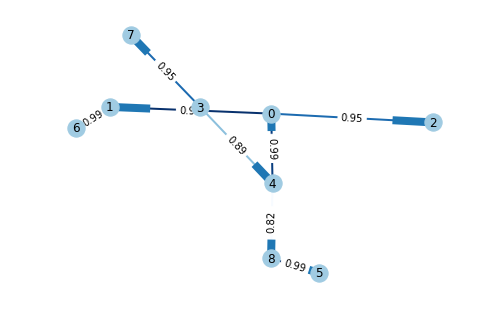

####################################################################
Score: 7.578623436632789


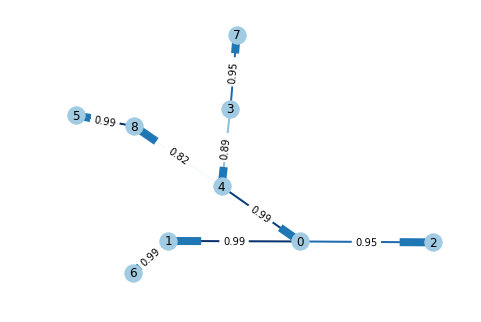

In [6]:
labels = ["nsubj", "dobj", "iobj", "det", "nmod", "amod", "cc", "conj"]
sentence = "Eins Zwei Drei Vier Funf Sechs Sieben Acht Neun".split()

matrix = np.random.random((len(sentence),len(sentence)))
graph,edges = matrix_to_graph(matrix, sentence, labels, digraph=True)


max_score = -np.inf
max_root = 0
for root in np.arange(0,len(sentence)):
    tree = max_tree(graph,root=root)
    maxim = get_score(tree)
    if maxim > max_score:
        max_score = maxim
        max_root = root

tree = max_tree(graph,root = max_root)
print("Score:", get_score(tree))
draw_nice(tree, custom_labels = False)


tree11 = minimum_tree(graph)
print("Score:", get_score(tree11))
draw_nice(tree11)